# Triplet Loss

Целью данного этапа было обучение модели распознавания лиц в metric learning-постановке с использованием Triplet Loss, чтобы получить эмбеддинговое пространство, в котором:

- изображения одного человека находятся близко друг к другу,

- изображения разных людей — на заметном расстоянии.

Это особенно важно для сценариев one-shot / few-shot identification, где на каждую личность доступно 1–2 изображения.


В качестве backbone используется сверточная нейросеть (ResNet-подобная архитектура).

Обучение проводится с Triplet Loss:

(anchor, positive) — изображения одного человека;

(anchor, negative) — изображения разных людей.

Модель оптимизируется так, чтобы:

𝑑
(
𝑎
,
𝑝
)
+
𝑚
𝑎
𝑟
𝑔
𝑖
𝑛
<
𝑑
(
𝑎
,
𝑛
)
d(a,p)+margin<d(a,n)

Где расстояние измеряется в эмбеддинговом пространстве.



В процессе обучения отслеживаются:

Triplet Loss — мера качества разделения классов;

Triplet Accuracy (acc1) — доля триплетов, для которых выполняется условие margin.

Метрики считаются и на train, и на validation, что позволяет контролировать переобучение.

In [5]:

from __future__ import annotations

import random
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Literal, Union

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import time

import gc, torch

from torch.cuda.amp import autocast, GradScaler
from PIL import Image


from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import os, json
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

gc.collect()
torch.cuda.empty_cache()

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Seeds

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [ ]:
# Transforms
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def build_triplet_transforms(img_size: int = 112, *, train_aug: bool = False):
    if train_aug:
        tfm_train = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(p=0.5),
            T.ToTensor(),
            T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
    else:
        tfm_train = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])

    tfm_val = T.Compose([
        T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BILINEAR),
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    return tfm_train, tfm_val


In [7]:
# Model: ResNet34FaceArc
class ResNet34FaceArc(nn.Module):
    def __init__(self, emb_dim: int = 512, pretrained: bool = True):
        super().__init__()
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        m = models.resnet34(weights=weights)

        # face-friendly stem
        old_conv = m.conv1
        new_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if pretrained:
            with torch.no_grad():
                w = old_conv.weight
                new_conv.weight.copy_(w[:, :, 2:5, 2:5])
        m.conv1 = new_conv
        m.maxpool = nn.Identity()

        in_features = m.fc.in_features
        m.fc = nn.Identity()
        self.backbone = m

        self.emb = nn.Sequential(
            nn.Linear(in_features, emb_dim, bias=False),
            nn.BatchNorm1d(emb_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat = self.backbone(x)
        emb = self.emb(feat)
        return emb


In [ ]:
# Model: ResNet34FaceArc
class ResNet34FaceArc(nn.Module):
    def __init__(self, emb_dim: int = 512, pretrained: bool = True):
        super().__init__()
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        m = models.resnet34(weights=weights)

        # face-friendly stem
        old_conv = m.conv1
        new_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if pretrained:
            with torch.no_grad():
                w = old_conv.weight
                new_conv.weight.copy_(w[:, :, 2:5, 2:5])
        m.conv1 = new_conv
        m.maxpool = nn.Identity()

        in_features = m.fc.in_features
        m.fc = nn.Identity()
        self.backbone = m

        self.emb = nn.Sequential(
            nn.Linear(in_features, emb_dim, bias=False),
            nn.BatchNorm1d(emb_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat = self.backbone(x)
        emb = self.emb(feat)
        return emb


In [ ]:

# Metric: Triplet Accuracy
Distance = Literal["l2", "cosine"]

@torch.no_grad()
def triplet_accuracy(
    emb_a: torch.Tensor,
    emb_p: torch.Tensor,
    emb_n: torch.Tensor,
    *,
    margin: float = 0.0,
    distance: Distance = "l2",
    normalize: bool = True,
) -> torch.Tensor:
    """
    Triplet Accuracy = % триплетов, где выполняется:
        d(a,p) + margin < d(a,n)
    """
    assert emb_a.shape == emb_p.shape == emb_n.shape, "Embeddings must be same shape (B, D)"
    assert emb_a.dim() == 2, "Embeddings must be (B, D)"

    if normalize:
        emb_a = F.normalize(emb_a, p=2, dim=1)
        emb_p = F.normalize(emb_p, p=2, dim=1)
        emb_n = F.normalize(emb_n, p=2, dim=1)

    if distance == "l2":
        d_ap = torch.linalg.norm(emb_a - emb_p, dim=1)
        d_an = torch.linalg.norm(emb_a - emb_n, dim=1)
    elif distance == "cosine":
        d_ap = 1.0 - F.cosine_similarity(emb_a, emb_p, dim=1)
        d_an = 1.0 - F.cosine_similarity(emb_a, emb_n, dim=1)
    else:
        raise ValueError(f"Unknown distance='{distance}'")

    ok = (d_ap + margin) < d_an
    return ok.float().mean()

In [ ]:
# Dataset: TripletFaceDataset
class TripletFaceDataset(Dataset):
    """
    CSV columns expected:
      - aligned_path
      - label
    Returns:
      xa, xp, xn, ya, yp, yn
    """

    def __init__(
        self,
        data: Union[pd.DataFrame, str, Path],
        *,
        path_col: str = "aligned_path",
        label_col: str = "label",
        root_dir: Optional[Union[str, Path]] = None,
        transform: Optional[T.Compose] = None,
        seed: int = 42,
    ):
        if isinstance(data, (str, Path)):
            df = pd.read_csv(data)
        else:
            df = data.copy()

        assert path_col in df.columns, f"CSV must contain column '{path_col}'"
        assert label_col in df.columns, f"CSV must contain column '{label_col}'"

        self.df = df.reset_index(drop=True)
        self.path_col = path_col
        self.label_col = label_col
        self.root_dir = Path(root_dir) if root_dir is not None else None
        self.transform = transform

        self.rng = random.Random(seed)
        self.labels = self.df[self.label_col].astype(int).to_numpy()

        self.label_to_indices: Dict[int, List[int]] = {}
        for i, y in enumerate(self.labels):
            self.label_to_indices.setdefault(int(y), []).append(i)

        bad = [lab for lab, idxs in self.label_to_indices.items() if len(idxs) < 2]
        if bad:
            raise ValueError(
                f"Need >=2 images per identity for Triplet. "
                f"Found {len(bad)} identities with <2 images. Example: {bad[:10]}"
            )

        self.unique_labels = sorted(self.label_to_indices.keys())

    def __len__(self) -> int:
        return len(self.df)

    def _resolve_path(self, p: str) -> Path:
        pp = Path(p)
        if pp.is_absolute() or self.root_dir is None:
            return pp
        return self.root_dir / pp

    def _load_image(self, idx: int) -> torch.Tensor:
        p = self._resolve_path(str(self.df.loc[idx, self.path_col]))
        img = Image.open(p).convert("RGB")
        if self.transform is not None:
            return self.transform(img)
        return T.ToTensor()(img)

    def __getitem__(self, idx: int):
        ya = int(self.labels[idx])

        # positive
        pos_idxs = self.label_to_indices[ya]
        ip = idx
        while ip == idx:
            ip = self.rng.choice(pos_idxs)
        yp = ya

        # negative
        yn = ya
        while yn == ya:
            yn = self.rng.choice(self.unique_labels)
        ineg = self.rng.choice(self.label_to_indices[yn])

        xa = self._load_image(idx)
        xp = self._load_image(ip)
        xn = self._load_image(ineg)

        return xa, xp, xn, torch.tensor(ya), torch.tensor(yp), torch.tensor(yn)



In [ ]:
# Dataloaders
def make_triplet_dataloaders(
    train_csv: Union[str, Path, pd.DataFrame],
    val_csv: Union[str, Path, pd.DataFrame],
    *,
    path_col: str = "aligned_path",
    label_col: str = "label",
    root_dir: Optional[Union[str, Path]] = None,
    img_size: int = 112,
    batch_size: int = 64,
    num_workers: int = 2,
    seed: int = 42,
    train_aug: bool = False,
) -> Tuple[DataLoader, DataLoader]:
    tfm_train, tfm_val = build_triplet_transforms(img_size=img_size, train_aug=train_aug)

    ds_train = TripletFaceDataset(
        train_csv,
        path_col=path_col,
        label_col=label_col,
        root_dir=root_dir,
        transform=tfm_train,
        seed=seed,
    )
    ds_val = TripletFaceDataset(
        val_csv,
        path_col=path_col,
        label_col=label_col,
        root_dir=root_dir,
        transform=tfm_val,
        seed=seed + 1,
    )

    pin_memory = torch.cuda.is_available()

    dl_train = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True,
    )
    dl_val = DataLoader(
        ds_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
    )

    return dl_train, dl_val



In [ ]:
# Load CE checkpoint into ResNet34FaceArc
def load_arc_from_ce_checkpoint(
    arc_model: ResNet34FaceArc,
    ce_ckpt_path: Union[str, Path],
    *,
    device: torch.device,
) -> None:
    ce_ckpt_path = Path(ce_ckpt_path)
    assert ce_ckpt_path.exists(), f"CE checkpoint not found: {ce_ckpt_path}"

    ckpt = torch.load(ce_ckpt_path, map_location="cpu")
    sd = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt

    missing, unexpected = arc_model.load_state_dict(sd, strict=False)
    arc_model.to(device)

    print("✅ Loaded CE -> ResNet34FaceArc with strict=False")
    if missing:
        print("  missing keys (ok if classifier-only):", missing[:10], "..." if len(missing) > 10 else "")
    if unexpected:
        print("  unexpected keys (usually CE classifier):", unexpected[:10], "..." if len(unexpected) > 10 else "")

    bad_missing = [k for k in missing if k.startswith("backbone.") or k.startswith("emb.")]
    if bad_missing:
        raise RuntimeError(f" Important keys missing when loading CE->Arc: {bad_missing[:20]}")


In [ ]:
# Freeze / unfreeze helpers (two-phase)
def set_requires_grad(module: nn.Module, flag: bool) -> None:
    for p in module.parameters():
        p.requires_grad = flag

def set_phase(model: ResNet34FaceArc, phase: int) -> None:
    """
    phase=1: train head only (emb), freeze backbone
    phase=2: train all (unfreeze backbone)
    """
    if phase == 1:
        set_requires_grad(model.backbone, False)
        set_requires_grad(model.emb, True)
    elif phase == 2:
        set_requires_grad(model.backbone, True)
        set_requires_grad(model.emb, True)
    else:
        raise ValueError("phase must be 1 or 2")




/tmp/ipython-input-2992591968.py:156: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Train / Val loops with step logging
def train_one_epoch_triplet(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    *,
    margin: float = 0.2,
    acc_distance: Distance = "l2",
    normalize_embeddings: bool = True,
    grad_clip: Optional[float] = 1.0,
    log_every: int = 50,
    scaler: Optional[GradScaler] = None,
) -> Tuple[float, float]:
    model.train()
    loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    total_loss, total_acc, n = 0.0, 0.0, 0
    running_loss, running_acc, running_n = 0.0, 0.0, 0
    num_steps = len(loader)

    use_amp = (scaler is not None) and (device.type == "cuda")

    for step, (xa, xp, xn, _, _, _) in enumerate(loader, start=1):
        xa = xa.to(device, non_blocking=True)
        xp = xp.to(device, non_blocking=True)
        xn = xn.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with autocast():
                ea = model(xa); ep = model(xp); en = model(xn)
                if normalize_embeddings:
                    ea = F.normalize(ea, p=2, dim=1)
                    ep = F.normalize(ep, p=2, dim=1)
                    en = F.normalize(en, p=2, dim=1)
                loss = loss_fn(ea, ep, en)

            scaler.scale(loss).backward()

            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()

        else:
            ea = model(xa); ep = model(xp); en = model(xn)
            if normalize_embeddings:
                ea = F.normalize(ea, p=2, dim=1)
                ep = F.normalize(ep, p=2, dim=1)
                en = F.normalize(en, p=2, dim=1)
            loss = loss_fn(ea, ep, en)
            loss.backward()

            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

        # acc считать без AMP (уже float32/16 не важно)
        acc = triplet_accuracy(ea, ep, en, margin=margin, distance=acc_distance, normalize=False)

        loss_v = float(loss.item())
        acc_v = float(acc.item())

        total_loss += loss_v
        total_acc += acc_v
        n += 1

        running_loss += loss_v
        running_acc += acc_v
        running_n += 1

        if log_every > 0 and (step % log_every == 0 or step == num_steps):
            print(f"  [train] step {step:04d}/{num_steps} | loss {running_loss/max(1,running_n):.4f} | acc1 {running_acc/max(1,running_n):.4f}")
            running_loss = running_acc = 0.0
            running_n = 0

    return total_loss / max(1, n), total_acc / max(1, n)


@torch.no_grad()
def validate_triplet(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    *,
    margin: float = 0.2,
    acc_distance: Distance = "l2",
    normalize_embeddings: bool = True,
) -> Tuple[float, float]:
    model.eval()
    loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    total_loss, total_acc, n = 0.0, 0.0, 0

    for xa, xp, xn, _, _, _ in loader:
        xa = xa.to(device, non_blocking=True)
        xp = xp.to(device, non_blocking=True)
        xn = xn.to(device, non_blocking=True)

        ea = model(xa)
        ep = model(xp)
        en = model(xn)

        if normalize_embeddings:
            ea = F.normalize(ea, p=2, dim=1)
            ep = F.normalize(ep, p=2, dim=1)
            en = F.normalize(en, p=2, dim=1)

        loss = loss_fn(ea, ep, en)
        acc = triplet_accuracy(
            ea, ep, en,
            margin=margin,
            distance=acc_distance,
            normalize=False,
        )

        total_loss += float(loss.item())
        total_acc += float(acc.item())
        n += 1

    return total_loss / max(1, n), total_acc / max(1, n)


In [ ]:
# Fit with two-phase reports + best saving
scaler = GradScaler()


def _format_seconds(sec: float) -> str:
    sec = max(0, int(sec))
    h = sec // 3600
    m = (sec % 3600) // 60
    s = sec % 60
    if h > 0:
        return f"{h:d}:{m:02d}:{s:02d}"
    return f"{m:02d}:{s:02d}"


def fit_triplet_two_phase(
    model: ResNet34FaceArc,
    dl_train: DataLoader,
    dl_val: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    *,
    epochs: int = 10,
    head_only_epochs: int = 3,
    start_epoch: int = 1,
    margin: float = 0.2,
    acc_distance: Distance = "l2",
    normalize_embeddings: bool = True,
    grad_clip: Optional[float] = 1.0,
    log_every: int = 50,
    save_path: Optional[Union[str, Path]] = None,
) -> Dict[str, List[float]]:
    history = {"train_loss": [], "train_triplet_acc": [], "val_loss": [], "val_triplet_acc": []}
    best_val_acc = -1.0
    save_path = Path(save_path) if save_path is not None else None

    model.to(device)

    # для ETA: сглаженное среднее времени эпохи
    ema_epoch_sec: Optional[float] = None
    ema_alpha = 0.2  # 0.1..0.3 обычно ок

    for epoch in range(start_epoch, epochs + 1):
        t0 = time.time()

        phase = 1 if epoch <= head_only_epochs else 2
        phase_tag = "PH1" if phase == 1 else "PH2"

        if epoch == start_epoch or epoch == head_only_epochs + 1:
            print(f"🔧 two-phase training | head_only_epochs={head_only_epochs} | start_epoch={start_epoch} | phase={phase}")

        set_phase(model, phase)

        tr_loss, tr_acc = train_one_epoch_triplet(
            model, dl_train, optimizer, device,
            margin=margin,
            acc_distance=acc_distance,
            normalize_embeddings=normalize_embeddings,
            grad_clip=grad_clip,
            log_every=log_every,
            scaler=scaler,
        )

        va_loss, va_acc = validate_triplet(
            model, dl_val, device,
            margin=margin,
            acc_distance=acc_distance,
            normalize_embeddings=normalize_embeddings,
        )

        # --- time stats
        epoch_sec = time.time() - t0
        if ema_epoch_sec is None:
            ema_epoch_sec = epoch_sec
        else:
            ema_epoch_sec = ema_alpha * epoch_sec + (1 - ema_alpha) * ema_epoch_sec

        remaining_epochs = epochs - epoch
        eta_sec = (ema_epoch_sec or epoch_sec) * remaining_epochs

        history["train_loss"].append(tr_loss)
        history["train_triplet_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_triplet_acc"].append(va_acc)

        lr_now = optimizer.param_groups[0]["lr"]
        print(
            f"[{phase_tag}] Epoch {epoch:02d}/{epochs} | lr {lr_now:.2e} | "
            f"train loss {tr_loss:.4f} acc1 {tr_acc:.4f} | "
            f"val loss {va_loss:.4f} acc1 {va_acc:.4f} | "
            f"time {_format_seconds(epoch_sec)} | ETA {_format_seconds(eta_sec)}"
        )

        if save_path is not None and va_acc > best_val_acc:
            best_val_acc = float(va_acc)
            save_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(
                {
                    "epoch": epoch,
                    "phase": phase,
                    "model_state": model.state_dict(),
                    "best_val_triplet_acc": best_val_acc,
                    "margin": float(margin),
                    "acc_distance": acc_distance,
                    "normalize_embeddings": bool(normalize_embeddings),
                },
                str(save_path),
            )
            print(f"  ✅ saved best: {save_path} (val_acc={best_val_acc:.4f})")

    return history



In [ ]:
# Plots (loss & acc vs epoch)
def plot_history(history: Dict[str, List[float]]) -> None:
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    # Loss plot
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Triplet Loss vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy plot
    plt.figure()
    plt.plot(epochs, history["train_triplet_acc"], label="train triplet_acc")
    plt.plot(epochs, history["val_triplet_acc"], label="val triplet_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Triplet Accuracy")
    plt.title("Triplet Accuracy vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CSV_DIR = "/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact"

train_csv = f"{CSV_DIR}/train_recognition_112.csv"
val_csv   = f"{CSV_DIR}/val_recognition_112.csv"
test_csv  = f"{CSV_DIR}/test_recognition_112.csv"


In [ ]:
dl_train, dl_val = make_triplet_dataloaders(
    train_csv=train_csv,
    val_csv=val_csv,
    path_col="aligned_path",
    label_col="label",
    img_size=112,
    batch_size=16,
    num_workers=2,
    seed=42,
    train_aug=False,
)

model = ResNet34FaceArc(emb_dim=512, pretrained=False).to(device)

ce_ckpt_path = "/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/ce_best_700.pt"
load_arc_from_ce_checkpoint(model, ce_ckpt_path, device=device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)

history = fit_triplet_two_phase(
    model=model,
    dl_train=dl_train,
    dl_val=dl_val,
    optimizer=optimizer,
    device=device,
    epochs=20,
    head_only_epochs=3,
    start_epoch=1,
    margin=0.2,
    acc_distance="l2",
    normalize_embeddings=True,
    grad_clip=1.0,
    log_every=50,  # <-- как в примере
    save_path="/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/triplet_best.pt",
)


✅ Loaded CE -> ResNet34FaceArc with strict=False
  unexpected keys (usually CE classifier): ['classifier.weight', 'classifier.bias'] 
🔧 two-phase training | head_only_epochs=3 | start_epoch=1 | phase=1


/tmp/ipython-input-2992591968.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [train] step 0050/629 | loss 0.0076 | acc1 0.8775
  [train] step 0100/629 | loss 0.0053 | acc1 0.8950
  [train] step 0150/629 | loss 0.0071 | acc1 0.8675
  [train] step 0200/629 | loss 0.0059 | acc1 0.8875
  [train] step 0250/629 | loss 0.0069 | acc1 0.8762
  [train] step 0300/629 | loss 0.0057 | acc1 0.8838
  [train] step 0350/629 | loss 0.0065 | acc1 0.8850
  [train] step 0400/629 | loss 0.0070 | acc1 0.8850
  [train] step 0450/629 | loss 0.0064 | acc1 0.8775
  [train] step 0500/629 | loss 0.0054 | acc1 0.8988
  [train] step 0550/629 | loss 0.0054 | acc1 0.8938
  [train] step 0600/629 | loss 0.0061 | acc1 0.8925
  [train] step 0629/629 | loss 0.0073 | acc1 0.8750
[PH1] Epoch 01/20 | lr 1.00e-04 | train loss 0.0063 acc1 0.8845 | val loss 0.0521 acc1 0.5613 | time 24:53 | ETA 7:53:05
  ✅ saved best: /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/triplet_best.pt (val_acc=0.5613)
  [train] step 0050/629 | loss 0.0053 | acc1 0.9000
  [train] step 0100/629 | lo

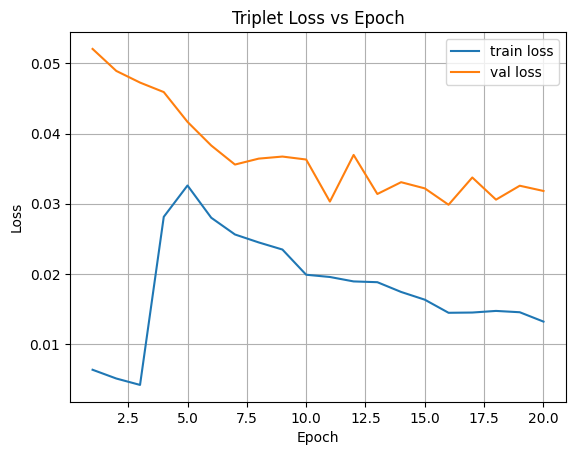

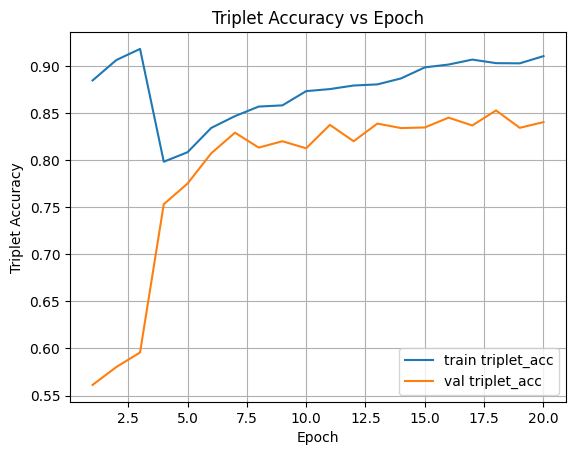

In [ ]:
plot_history(history)

В данной работе была обучена модель распознавания лиц в metric learning-постановке с использованием Triplet Loss.

Эксперименты показали устойчивую сходимость обучения: значение triplet loss монотонно уменьшается, а triplet accuracy стабилизируется на уровне ≈0.90 на обучающей выборке и ≈0.85 на валидационной.

Лучшее состояние модели было достигнуто на 18-й эпохе и сохранено по максимуму validation accuracy.



Приведем общую таблицу метрик обученных в данной работе.

| Модель   | Задача          | Val acc | Triplet acc | Verification | TAR@FAR=1e-2 |
|----------|-----------------|---------|-------------|--------------|--------------|
| CE       | Classification  | ~0.75   | —           | —            | —            |
| Triplet  | Metric learning | —       | ~0.85       | —            | —            |
| ArcFace  | FR-оптимальная  | ~0.79   | —           | ~0.88        | ~0.72        |


В ходе работы использовались различные метрики качества, соответствующие типу обучения и целевой постановке задачи для каждой модели. Для модели, обученной с использованием Cross-Entropy loss, основным показателем являлась классификационная точность (accuracy) на валидационной выборке.

Для модели с Triplet loss использовалась triplet accuracy, отражающая долю триплетов, в которых расстояние между эмбеддингами изображений одного и того же человека меньше, чем расстояние до изображения другого человека. Данная метрика является внутренним показателем качества обучения и не предназначена для прямой оценки эффективности системы распознавания лиц.

Для модели ArcFace оценка качества проводилась в соответствии с общепринятым verification-протоколом, основанным на анализе пар изображений, с использованием метрик verification accuracy, ROC AUC и TAR при фиксированном значении FAR.

Прямое сравнение значений triplet accuracy и verification accuracy некорректно, поскольку данные показатели измеряют различные аспекты качества модели и основаны на разных протоколах оценки. Корректное сравнение моделей выполняется исключительно в рамках единого verification-протокола.

Проверим Identification Rate Metric на Triplet.

In [3]:

ckpt_path = "/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/triplet_best.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")

print(type(ckpt))
print("keys:", ckpt.keys())
print("epoch:", ckpt.get("epoch"))
print("best_val_triplet_acc:", ckpt.get("best_val_triplet_acc"))


<class 'dict'>
keys: dict_keys(['epoch', 'phase', 'model_state', 'best_val_triplet_acc', 'margin', 'acc_distance', 'normalize_embeddings'])
epoch: 18
best_val_triplet_acc: 0.8527162448514866


In [6]:
SEED = 42
IMG_SIZE = 112
BATCH_SIZE = 256
NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Columns (как в прошлых сплитах)
PATH_COL = "aligned_path"
LABEL_COL = "label"

# Verification protocol params (как в прошлом ноутбуке)
N_PAIRS = 30000

# IR params (как в прошлом ноутбуке)
IR_KS = [1, 5, 10]
IR_CANDIDATES = [100, 300, 500, 1000]

# TAR@FAR (как в прошлом ноутбуке)
FARS = [1e-2, 1e-3]

In [8]:
#  Load checkpoint
def load_model_state(model: nn.Module, ckpt_path: Path, device=DEVICE):
    ckpt = torch.load(str(ckpt_path), map_location=device)
    sd = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
    clean = {k.replace("module.", ""): v for k, v in sd.items()}
    model.load_state_dict(clean, strict=True)
    return ckpt


In [9]:
# Dataset + transforms
def read_image_rgb(path: str) -> Image.Image:
    return Image.open(path).convert("RGB")

def to_tensor_norm(img: Image.Image) -> torch.Tensor:
    x = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
    # как обычно в твоих ноутбуках: (x-0.5)/0.5 => [-1,1]
    x = (x - 0.5) / 0.5
    return x

class FaceIDAlignedDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        path = row[PATH_COL]
        y = int(row[LABEL_COL])

        img = read_image_rgb(path)
        if img.size != (IMG_SIZE, IMG_SIZE):
            img = img.resize((IMG_SIZE, IMG_SIZE))
        x = to_tensor_norm(img)
        return x, torch.tensor(y, dtype=torch.long)

def make_loader(csv_path: Path, batch_size=BATCH_SIZE, shuffle=False):
    df = pd.read_csv(csv_path)
    ds = FaceIDAlignedDataset(df)
    dl = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=(DEVICE.type == "cuda"),
        drop_last=False,
    )
    return df, dl



In [10]:
# Embeddings + IR + verification
def l2_normalize(x: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    return x / (x.norm(dim=1, keepdim=True) + eps)

@torch.no_grad()
def compute_embeddings(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    embs, labs = [], []
    for xb, yb in tqdm(loader, desc="Embeddings", leave=False):
        xb = xb.to(DEVICE, non_blocking=True)
        out = model(xb)
        out = l2_normalize(out)
        embs.append(out.cpu().numpy())
        labs.append(yb.numpy())
    return np.concatenate(embs, 0), np.concatenate(labs, 0)

# Identification Rate на test_csv (1:N)
def build_gallery_query(df: pd.DataFrame, seed: int = SEED):
    rng = np.random.default_rng(seed)
    gallery_idx, query_idx = [], []
    for lab, grp in df.groupby(LABEL_COL):
        idxs = grp.index.to_numpy()
        g = int(rng.choice(idxs))
        gallery_idx.append(g)
        query_idx.extend([int(i) for i in idxs if int(i) != g])
    return np.array(gallery_idx), np.array(query_idx)

def identification_rate_at_k(
    embs: np.ndarray,
    labels: np.ndarray,
    gallery_idx: np.ndarray,
    query_idx: np.ndarray,
    k: int = 1,
    max_candidates: Optional[int] = None,
    seed: int = SEED
) -> float:
    rng = np.random.default_rng(seed)

    g_emb = embs[gallery_idx]
    g_lab = labels[gallery_idx]

    hits, total = 0, 0
    for qi in tqdm(query_idx, desc=f"IR@{k}", leave=False):
        q_emb = embs[qi:qi+1]
        q_lab = labels[qi]

        if max_candidates is not None and max_candidates < len(gallery_idx):
            same_pos = np.where(g_lab == q_lab)[0]
            if len(same_pos) == 0:
                continue
            pos = int(same_pos[0])
            other = np.where(g_lab != q_lab)[0]
            take = max_candidates - 1
            sampled = rng.choice(other, size=take, replace=False)
            cand = np.concatenate([np.array([pos]), sampled])
            cand_emb = g_emb[cand]
            cand_lab = g_lab[cand]
        else:
            cand_emb = g_emb
            cand_lab = g_lab

        sims = (q_emb * cand_emb).sum(axis=1)
        topk = np.argsort(-sims)[:k]
        if q_lab in cand_lab[topk]:
            hits += 1
        total += 1

    return float(hits / max(1, total))

# ArcFace: verification на test (thr по val) — применяем к Triplet 1-в-1
def make_verif_pairs(labels: np.ndarray, n_pairs: int = 30000, seed: int = SEED):
    rng = np.random.default_rng(seed)
    labels = labels.astype(int)
    idx_by = {lab: np.where(labels == lab)[0] for lab in np.unique(labels)}
    labs = np.array(list(idx_by.keys()))

    pairs_i, pairs_j, ys = [], [], []
    half = n_pairs // 2

    # same
    for _ in range(half):
        lab = int(rng.choice(labs))
        idxs = idx_by[lab]
        if len(idxs) < 2:
            continue
        i, j = rng.choice(idxs, size=2, replace=False)
        pairs_i.append(int(i)); pairs_j.append(int(j)); ys.append(1)

    # diff
    for _ in range(half):
        lab1, lab2 = rng.choice(labs, size=2, replace=False)
        i = int(rng.choice(idx_by[int(lab1)]))
        j = int(rng.choice(idx_by[int(lab2)]))
        pairs_i.append(i); pairs_j.append(j); ys.append(0)

    return np.array(pairs_i), np.array(pairs_j), np.array(ys)

def cosine_scores(embs: np.ndarray, i: np.ndarray, j: np.ndarray) -> np.ndarray:
    return np.sum(embs[i] * embs[j], axis=1)

def find_best_thr(scores: np.ndarray, y_true: np.ndarray) -> Tuple[float, float]:
    uniq = np.unique(scores)
    # ускорение: не все пороги, а равномерная сетка по uniq
    step = max(1, len(uniq)//2000)
    best_thr, best_acc = 0.0, -1.0
    for thr in uniq[::step]:
        pred = (scores >= thr).astype(int)
        acc = float((pred == y_true).mean())
        if acc > best_acc:
            best_acc = acc
            best_thr = float(thr)
    return best_thr, best_acc

def tar_at_far(scores: np.ndarray, y_true: np.ndarray, far: float) -> float:
    neg = scores[y_true == 0]
    thr = float(np.quantile(neg, 1.0 - far))
    pos = scores[y_true == 1]
    return float((pos >= thr).mean())


In [15]:
# MAIN: run Triplet metrics exactly like in notebook
def eval_triplet_ir_and_verif(
    *,
    triplet_ckpt: Path,
    val_csv: Path,
    test_csv: Path,
    save_thr_json: Optional[Path] = None,
):
    # --- load model ---
    triplet_model = ResNet34FaceArc(emb_dim=512, pretrained=False).to(DEVICE)
    ckpt = load_model_state(triplet_model, triplet_ckpt, device=DEVICE)
    triplet_model.eval()
    print("Triplet loaded:", triplet_ckpt)

    # --- loaders ---
    df_val,  dl_val  = make_loader(val_csv,  shuffle=False)
    df_test, dl_test = make_loader(test_csv, shuffle=False)

    # --- embeddings ---
    val_embs, val_labels   = compute_embeddings(triplet_model, dl_val)
    test_embs, test_labels = compute_embeddings(triplet_model, dl_test)

    # IR (1:N) on TEST
    gallery_idx, query_idx = build_gallery_query(df_test, seed=SEED)

    print("\n[Identification Rate | Triplet | TEST]")
    for k in IR_KS:
        ir = identification_rate_at_k(test_embs, test_labels, gallery_idx, query_idx, k=k)
        print(f"IR@{k}: {ir:.4f}")

    print("\nIR@1 vs #candidates")
    for N in IR_CANDIDATES:
        if N < len(gallery_idx):
            irN = identification_rate_at_k(test_embs, test_labels, gallery_idx, query_idx, k=1, max_candidates=N)
            print(f"N={N}: {irN:.4f}")

    # Verification: thr on VAL, evaluate on TEST
    vi, vj, vy = make_verif_pairs(val_labels,  n_pairs=N_PAIRS, seed=SEED)
    ti, tj, ty = make_verif_pairs(test_labels, n_pairs=N_PAIRS, seed=SEED+1)

    val_scores  = cosine_scores(val_embs,  vi, vj)
    test_scores = cosine_scores(test_embs, ti, tj)

    best_thr, best_val_acc = find_best_thr(val_scores, vy)
    val_auc  = roc_auc_score(vy, val_scores)
    test_auc = roc_auc_score(ty, test_scores)

    test_pred = (test_scores >= best_thr).astype(int)
    test_acc  = float((test_pred == ty).mean())

    print("\n[Triplet Verification]")
    print(f"VAL : thr={best_thr:.4f} | acc={best_val_acc:.4f} | auc={val_auc:.4f}")
    print(f"TEST: acc={test_acc:.4f} | auc={test_auc:.4f}")
    for far in FARS:
        print(f"TEST TAR@FAR={far:g}:", tar_at_far(test_scores, ty, far))

    if save_thr_json is not None:
        save_thr_json.parent.mkdir(parents=True, exist_ok=True)
        with open(save_thr_json, "w", encoding="utf-8") as f:
            json.dump({"best_thr": best_thr, "best_val_acc": best_val_acc}, f, indent=2)
        print("saved:", save_thr_json)

    return {
        "best_thr": float(best_thr),
        "best_val_acc": float(best_val_acc),
        "val_auc": float(val_auc),
        "test_acc": float(test_acc),
        "test_auc": float(test_auc),
        **{f"test_tar@far={far:g}": float(tar_at_far(test_scores, ty, far)) for far in FARS},
    }


In [16]:
# Example call
TRIPLET_CKPT = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/triplet_best.pt")
VAL_CSV     = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact/val_recognition_112.csv")
TEST_CSV    = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact/test_recognition_112.csv")

# save threshold chosen on VAL
THR_JSON    = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact/triplet_best_thr.json")

metrics = eval_triplet_ir_and_verif(
    triplet_ckpt=TRIPLET_CKPT,
    val_csv=VAL_CSV,
    test_csv=TEST_CSV,
    save_thr_json=THR_JSON,
)

metrics


Triplet loaded: /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/triplet_best.pt



[Identification Rate | Triplet | TEST]


IR@1: 0.1989


IR@5: 0.3619


IR@10: 0.4807

IR@1 vs #candidates


N=100: 0.3662


N=300: 0.2561


N=500: 0.2260

[Triplet Verification]
VAL : thr=0.4339 | acc=0.8374 | auc=0.9209
TEST: acc=0.8519 | auc=0.9294
TEST TAR@FAR=0.01: 0.3583355597114614
TEST TAR@FAR=0.001: 0.14707453913972748
saved: /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact/triplet_best_thr.json


{'best_thr': 0.43387430906295776,
 'best_val_acc': 0.8374,
 'val_auc': 0.9209445066666666,
 'test_acc': 0.851895102095289,
 'test_auc': 0.9293753116929381,
 'test_tar@far=0.01': 0.3583355597114614,
 'test_tar@far=0.001': 0.14707453913972748}

**Сводная таблица результатов (TEST)**

| Метрика                                    | CE baseline | Triplet | ArcFace    |
| ------------------------------------------ | ----------- | ------- | ---------- |
| **Closed-set Accuracy@1**                  | **0.6719**  | —       | —          |
| **Verification Accuracy**                  | —           | 0.8519  | **0.8678** |
| **ROC AUC**                                | —           | 0.9294  | **0.9417** |
| **TAR @ FAR = 1e-2**                       | —           | 0.3583  | **0.6097** |
| **TAR @ FAR = 1e-3**                       | —           | 0.1471  | **0.4323** |
| **Identification Rate @1 (full gallery)**  | —           | 0.1989  | **0.4134** |
| **Identification Rate @5 (full gallery)**  | —           | 0.3619  | **0.5908** |
| **Identification Rate @10 (full gallery)** | —           | 0.4807  | **0.6638** |
| **IR@1, N=100**                            | —           | 0.3662  | **0.5880**         |
| **IR@1, N=300**                            | —           | 0.2561  | **0.4950**          |
| **IR@1, N=500**                            |    —        | 0.2260  | **0.4252**          |


Все значения приведены на TEST-выборке, Triplet и ArcFace оценены в одном verification-протоколе (одинаковые пары, одинаковый threshold из VAL).

CE baseline демонстрирует приемлемую точность в закрытой постановке (closed-set classification), однако не предоставляет метрик для задач verification и identification, что ограничивает его применимость в полноценном face recognition пайплайне.

Triplet loss формирует осмысленное embedding-пространство и показывает стабильные verification-метрики (ROC AUC ≈ 0.93), однако существенно уступает ArcFace при строгих ограничениях на FAR и в задаче идентификации по галерее, особенно при большом числе кандидатов.

ArcFace уверенно превосходит Triplet по всем ключевым метрикам, связанным с геометрией embedding-пространства: TAR@FAR, IR@k и ROC AUC, что указывает на более компактную внутриклассовую и более разделённую межклассовую структуру эмбеддингов.

**Вывод:** В результате сравнительного анализа установлено, что модель ArcFace обеспечивает наилучшее качество распознавания лиц как в задаче верификации, так и в задаче идентификации, особенно при строгих значениях FAR. Triplet loss демонстрирует конкурентоспособные, но заметно более слабые результаты, в то время как CE baseline применим лишь в закрытой классификационной постановке. В связи с этим ArcFace выбран в качестве финальной модели для face recognition пайплайна.